# Optimizing Serial Code
### Chris Rackauckas
### September 3rd, 2019
At the center of any fast parallel code is a fast serial code. Parallelism
is made to be a performance multiplier, so if you start from a bad position it
won't ever get much better. Thus the first thing that we need to do is understand
what makes code slow and how to avoid the pitfalls. This discussion of serial
code optimization will also directly motivate why we will be using Julia
throughout this course.

## Mental Model of a Memory

To start optimizing code you need a good mental model of a computer.

### High Level View

At the highest level you have a CPU's core memory which directly accesses a
L1 cache. The L1 cache has the fastest access, so things which will be needed
soon are kept there. However, it is filled from the L2 cache, which itself
is filled from the L3 cache, which is filled from the main memory. This bring
us to the first idea in optimizing code: using things that are already in
a closer cache can help the code run faster because it doesn't have to be
queried for and moved up this chain.

![](https://hackernoon.com/hn-images/1*nT3RAGnOAWmKmvOBnizNtw.png)

When something needs to be pulled directly from main memory this is known as a
*cache miss*. To understand the cost of a cache miss vs standard calculations,
take a look at [this classic chart](http://ithare.com/infographics-operation-costs-in-cpu-clock-cycles/).

(Cache-aware and cache-oblivious algorithms are methods which change their
indexing structure to optimize their use of the cache lines. We will return
to this when talking about performance of linear algebra.)

### Cache Lines and Row/Column-Major

Many algorithms in numerical
linear algebra are designed to minimize cache misses. Because of this chain,
many modern CPUs try to guess what you will want next in your cache. When
dealing with arrays, it will speculate ahead and grab what is known as a *cache
line*: the next chunk in the array. Thus, your algorithms will be faster if
you iterate along the values that it is grabbing.

The values that it grabs are the next values in the contiguous order of the
stored array. There are two common conventions: row major and column major.
Row major means that the linear array of memory is formed by stacking the
rows one after another, while column major puts the column vectors one after
another.

![](https://eli.thegreenplace.net/images/2015/column-major-2D.png)

*Julia, MATLAB, and Fortran are column major*. Python's numpy is row-major.

In [1]:
A = rand(100,100)
B = rand(100,100)
C = rand(100,100)
using BenchmarkTools
function inner_rows!(C,A,B)
  for i in 1:100, j in 1:100
    C[i,j] = A[i,j] + B[i,j]
  end
end
@btime inner_rows!(C,A,B)

  18.900 μs (0 allocations: 0 bytes)


In [2]:
function inner_cols!(C,A,B)
  for j in 1:100, i in 1:100
    C[i,j] = A[i,j] + B[i,j]
  end
end
@btime inner_cols!(C,A,B)

  9.600 μs (0 allocations: 0 bytes)


### Lower Level View: The Stack and the Heap

Locally, the stack is composed of a *stack* and a *heap*. The stack requires a
static allocation: it is ordered. Because it's ordered, it is very clear where
things are in the stack, and therefore accesses are very quick (think
instantanious). However, because this is static, it requires that the size
of the variables is known at compile time (to determine all of the variable
locations). Since that is not possible with all variables, there exists the
heap. The heap is essentially a stack of pointers to objects in memory. When
heap variables are needed, their values are pulled up the cache chain and
accessed.

![](https://bayanbox.ir/view/581244719208138556/virtual-memory.jpg)
![](https://camo.githubusercontent.com/ca96d70d09ce694363e44b93fd975bb3033898c1/687474703a2f2f7475746f7269616c732e6a656e6b6f762e636f6d2f696d616765732f6a6176612d636f6e63757272656e63792f6a6176612d6d656d6f72792d6d6f64656c2d352e706e67)

### Heap Allocations and Speed

Heap allocations are costly because they involve this pointer indirection,
so stack allocation should be done when sensible (it's not helpful for really
large arrays, but for small values like scalars it's essential!)

In [3]:
function inner_alloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = [A[i,j] + B[i,j]]
    C[i,j] = val[1]
  end
end
@btime inner_alloc!(C,A,B)

  257.800 μs (10000 allocations: 937.50 KiB)


In [4]:
function inner_noalloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = A[i,j] + B[i,j]
    C[i,j] = val[1]
  end
end
@btime inner_noalloc!(C,A,B)

  8.467 μs (0 allocations: 0 bytes)


Why does the array here get heap-allocated? It isn't able to prove/guerentee
at compile-time that the array's size will always be a given value, and thus
it allocates it to the heap. `@btime` tells us this allocation occured and
shows us the total heap memory that was taken. Meanwhile, the size of a Float64
number is known at compile-time (64-bits), and so this is stored onto the stack
and given a specific location that the compiler will be able to directly
address.

Note that one can use the StaticArrays.jl library to get statically-sized arrays
and thus arrays which are stack-allocated:

In [7]:
using StaticArrays
function static_inner_alloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = @SVector [A[i,j] + B[i,j]]
    C[i,j] = val[1]
  end
end
@btime static_inner_alloc!(C,A,B)

┌ Info: Precompiling StaticArrays [90137ffa-7385-5640-81b9-e52037218182]
└ @ Base loading.jl:1273


  9.600 μs (0 allocations: 0 bytes)


### Mutation to Avoid Heap Allocations

Many times you do need to write into an array, so how can you write into an
array without performing a heap allocation? The answer is mutation. Mutation
is changing the values of an already existing array. In that case, no free
memory has to be found to put the array (and no memory has to be freed by
the garbage collector).

In Julia, functions which mutate the first value are conventionally noted by
a `!`. See the difference between these two equivalent functions:

In [8]:
function inner_noalloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = A[i,j] + B[i,j]
    C[i,j] = val[1]
  end
end
@btime inner_noalloc!(C,A,B)

  8.433 μs (0 allocations: 0 bytes)


In [9]:
function inner_alloc(A,B)
  C = similar(A)
  for j in 1:100, i in 1:100
    val = A[i,j] + B[i,j]
    C[i,j] = val[1]
  end
end
@btime inner_alloc(A,B)

  13.200 μs (2 allocations: 78.20 KiB)


To use this algorithm effectively, the `!` algorithm assumes that the caller
already has allocated the output array to put as the output argument. If that
is not true, then one would need to manually allocate. The goal of that interface
is to give the caller control over the allocations to allow them to manually
reduce the total number of heap allocations and thus increase the speed.

### Julia's Broadcasting Mechanism

Wouldn't it be nice to not have to write the loop there? In many high level
languages this is simply called *vectorization*. In Julia, we will call it
*array vectorization* to distinguish it from the *SIMD vectorization* which
is common in lower level languages like C, Fortran, and Julia.

In Julia, if you use `.` on an operator it will transform it to the broadcasted
form. Broadcast is *lazy*: it will build up an entire `.`'d expression and then
call `broadcast!` on composed expression. This is customizable and
[documented in detail](https://docs.julialang.org/en/v1/manual/interfaces/#man-interfaces-broadcasting-1).
However, to a first approximation we can think of the broadcast mechanism as a
mechanism for building *fused expressions*. For example, the Julia code:

In [10]:
A .+ B .+ C;

under the hood lowers to something like:

In [11]:
map((a,b,c)->a+b+c,A,B,C);

where `map` is a function that just loops over the values element-wise.

**Take a quick second to think about why loop fusion may be an optimization.**

This about what would happen if you did not fuse the operations. We can write
that out as:

In [12]:
tmp = A .+ B
tmp .+ C;

Notice that if we did not fuse the expressions, we would need some place to put
the result of `A .+ B`, and that would have to be an array, which means it would
cause a heap allocation. Thus broadcast fusion eliminates the *temporary variable*
(colloquially called just a *temporary*).

In [13]:
function unfused(A,B,C)
  tmp = A .+ B
  tmp .+ C
end
@btime unfused(A,B,C);

  13.800 μs (4 allocations: 156.41 KiB)


In [14]:
fused(A,B,C) = A .+ B .+ C
@btime fused(A,B,C);

  7.567 μs (2 allocations: 78.20 KiB)


Note that we can also fuse the output by using `.=`. This is essentially the
vectorized version of a `!` function:

In [15]:
D = similar(A)
fused!(D,A,B,C) = (D .= A .+ B .+ C)
@btime fused!(D,A,B,C);

  4.571 μs (0 allocations: 0 bytes)


### Note on Broadcasting Function Calls

Julia allows for broadcasting the call `()` operator as well. `.()` will call
the function element-wise on all arguments, so `sin.(A)` will be the elementwise
sine function. This will fuse Julia like the other operators.

### Note on Vectorization and Speed

In articles on MATLAB, Python, R, etc., this is where you will be told to
vectorize your code. Notice from above that this isn't a performance difference
between writing loops and using vectorized broadcasts. This is not abnormal!
The reason why you are told to vectorize code in these other languages is because
they have a high per-operation overhead (which will be discussed further down).
This means that every call, like `+`, is costly in these languages. To get around
this issue and make the language usable, someone wrote and compiled the loop
for the C/Fortran function that does the broadcasted form (see numpy's Github repo).
Thus `A .+ B`'s MATLAB/Python/R equivalents are calling a single C function
to generally avoid the cost of function calls and thus are faster.

But this is not an intrinsic property of vectorization. Vectorization isn't
"fast" in these languages, it's just close to the correct speed. The reason
vectorization is recommended is because looping is slow in these languages.
Because looping isn't slow in Julia (or C, C++, Fortran, etc.), loops and vectorization
generally have the same speed. So use the one that works best for your code
without a care about performance.

(As a small side effect, these high level languages tend to allocate a lot of
temporary variables since the individual C kernels are written for specific
numbers of inputs and thus don't naturally fuse. Julia's broadcast mechanism
is just generating and JIT compiling Julia functions on the fly, and thus it
can accomodate the combinatorial explosion in the amount of choices just by
only compiling the combinations that are necessary for a specific code)

### Heap Allocations from Slicing

It's important to note that slices in Julia produce copies instead of views.
Thus for example:

In [16]:
A[50,50]

0.48810333600521516

allocates a new output. This is for safety, since if it pointed to the same
array then writing to it would change the original array. We can demonstrate
this by asking for a *view* instead of a copy.

In [17]:
@show A[1]
E = @view A[1:5,1:5]
E[1] = 2.0
@show A[1]

A[1] = 0.5338887482447907
A[1] = 2.0


2.0

However, this means that `@view A[1:5,1:5]` did not allocate an array (it does
allocate a pointer if the escape analysis is unable to prove that it can be
elided. This means that in small loops there will be no allocation, while if
the view is returned from a function for example it will allocate the pointer,
~80 bytes, but not the memory of the array. This means that it is O(1) in cost
but with a relatively small constant).

### Asymptopic Cost of Heap Allocations

Heap allocations have to locate and prepare a space in RAM that is proportional
to the amount of memory that is calcuated, which means that the cost of a heap
allocation for an array is O(n), with a large constant. As RAM begins to fill
up, this cost dramatically increases. If you run out of RAM, your computer
may begin to use *swap*, which is essentially RAM simulated on your hard drive.
Generally when you hit swap your performance is so dead that you may think that
your computation froze, but if you check your resource use you will notice that
it's actually just filled the RAM and starting to use the swap.

But think of it as O(n) with a large constant factor. This means that for
operations which only touch the data once, heap allocations can dominate the
computational cost:

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


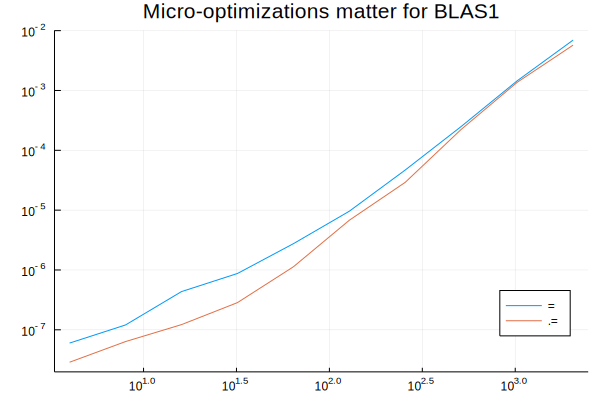

In [18]:
using LinearAlgebra, BenchmarkTools
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A .* $B
    t2 = @belapsed ($C .= $A .* $B)
    t1,t2
end
ns = 2 .^ (2:11)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

using Plots
plot(ns,alloc,label="=",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations matter for BLAS1")
plot!(ns,noalloc,label=".=")

However, when the computation takes O(n^3), like in matrix multiplications,
the high constant factor only comes into play when the matrices are sufficiently
small:

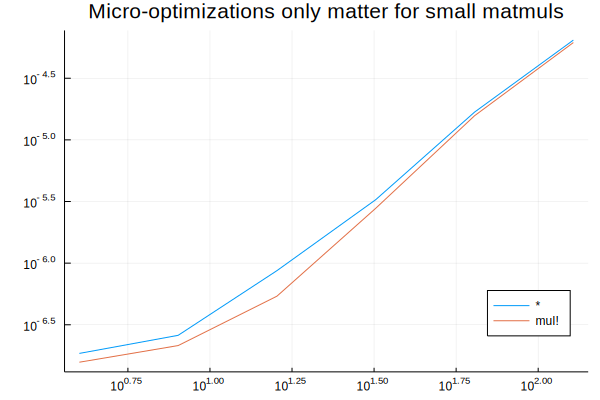

In [19]:
using LinearAlgebra, BenchmarkTools
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A*$B
    t2 = @belapsed mul!($C,$A,$B)
    t1,t2
end
ns = 2 .^ (2:7)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

using Plots
plot(ns,alloc,label="*",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations only matter for small matmuls")
plot!(ns,noalloc,label="mul!")

Though using a mutating form is never bad and always is a little bit better.

### Optimizing Memory Use Summary

- Avoid cache misses by reusing values
- Iterate along columns
- Avoid heap allocations in inner loops
- Heap allocations occur when the size of things is not proven at compile-time
- Use fused broadcasts (with mutated outputs) to avoid heap allocations
- Array vectorization confers no special benefit in Julia because Julia loops
  are as fast as C or Fortran
- Use views instead of slices when applicable
- Avoiding heap allocations is most necessary for O(n) algorithms or algorithms
  with small arrays
- Use StaticArrays.jl to avoid heap allocations of small arrays in inner loops

## Julia's Type Inference and the Compiler

Many people think Julia is fast because it is JIT compiled. That is simply not
true (we've already shown examples where Julia code isn't fast, but it's always
JIT compiled!). Instead, the reason why Julia is fast is because the combination
of two ideas:

- Type inference
- Type specialization in functions

These two features naturally give rise to Julia's core design feature: multiple
dispatch. Let's break down these pieces.

### Type Inference

At the core level of the computer, everything has a type. Some languages are
more explicit about said types, while others try to hide the types from the
user. A type tells the compiler how to to store and interpret the memory of a
value. For example, if the compiled code knows that the value in the register
is supposed to be interpreted as a 64-bit floating point number, then it
understands that slab of memory like:

![](https://i.stack.imgur.com/ZUbLc.png)

Importantly, it will know what to do for function calls. If the code tells it
to add two floating point numbers, it will send them as inputs to the
Floating Point Unit (FPU) which will give the output.

If the types are not known, then... ? So one cannot actually compute until
the types are known, since otherwise it's impossible to interpret the memory.
In languages like C, the programmer has to declare the types of
variables in the program:

```
void add(double *a, double *b, double *c, size_t n){
  size_t i;
  for(i = 0; i < n; ++i) {
    c[i] = a[i] + b[i];
  }
}
```

The types are known at compile time because the programmer set it in stone.
In many interpreted languages Python, types are checked at runtime. For example,

```
a = 2
b = 4
a + b
```

when the addition occurs, the Python interpreter will check the object holding
the values and ask it for its types, and use those types to know how to compute
the + function. For this reason, the add function in Python is rather complex
since it needs to decode and have a version for all primitive types!

Not only is there runtime overhead checks in function calls due to to not being
explicit about types, there is also a memory overhead since it is impossible
to know how much memory a value with take since that's a property of its type.
Thus the Python interpreter cannot statically guerentee exact unchanging values
for the size that a value would take in the stack, meaning that the variables
are not stack-allocated. This means that every number ends up heap-allocated,
which hopefully begins to explain why this is not as fast as C.

The solution is Julia is somewhat of a hybrid. The Julia code looks like:

In [ ]:
a = 2
b = 4
a + b

However, before JIT compilation, Julia runs a type inference algorithm which
finds out that `A` is an `Int`, and `B` is an `Int`. You can then understand
that if it can prove that `A+B` is an `Int`, then it can propogate all of the
types through.

### Type Specialization in Functions

Julia is able to propogate type inference through functions because, even if
a function is "untyped", Julia will interpret this as a *generic function*
over possible *methods*, where every method has a concrete type. This means that
in Julia, the function:

In [1]:
f(x,y) = x+y

f (generic function with 1 method)

is not what you may think of as a "single function", since given inputs of
different types it will actually be a different function. We can see this by
examining the *LLVM IR* (LLVM is Julia's compiler, the IR is the
*Intermediate Representation*, i.e. a platform-independent representation
of assembly that lives in LLVM that it knows how to convert into assembly per
architecture):

In [3]:
using InteractiveUtils
@code_llvm f(2,5)


;  @ In[1]:1 within `f'
define i64 @julia_f_17447(i64, i64) {
top:
; ┌ @ int.jl:53 within `+'
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [4]:
@code_llvm f(2.0,5.0)


;  @ In[1]:1 within `f'
define double @julia_f_17451(double, double) {
top:
; ┌ @ float.jl:401 within `+'
   %2 = fadd double %0, %1
; └
  ret double %2
}


Notice that when `f` is the function that takes in two `Int`s, `Int`s add to
give an `Int` and thus `f` outputs an `Int`. When `f` is the function that
takes two `Float64`s, `f` returns a `Float64`. Thus in the code:

In [5]:
function g(x,y)
  a = 4
  b = 2
  c = f(x,a)
  d = f(b,c)
  f(d,y)
end

@code_llvm g(2,5)


;  @ In[5]:2 within `g'
define i64 @julia_g_17453(i64, i64) {
top:
;  @ In[5]:5 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ int.jl:53 within `+'
    %2 = add i64 %0, 6
; └└
;  @ In[5]:6 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ int.jl:53 within `+'
    %3 = add i64 %2, %1
; └└
  ret i64 %3
}


`g` on two `Int` inputs is a function that has `Int`s at every step along the
way and spits out an `Int`. We can use the `@code_warntype` macro to better
see the inference along the steps of the function:

In [6]:
@code_warntype g(2,5)

Variables
  #self#::Core.Compiler.Const(g, false)
  x::Int64
  y::Int64
  a::Int64
  b::Int64
  c::Int64
  d::Int64

Body::Int64
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::Int64
└──      return %5


What happens on mixtures?

In [7]:
@code_llvm f(2.0,5)


;  @ In[1]:1 within `f'
define double @julia_f_17546(double, i64) {
top:
; ┌ @ promotion.jl:311 within `+'
; │┌ @ promotion.jl:282 within `promote'
; ││┌ @ promotion.jl:259 within `_promote'
; │││┌ @ number.jl:7 within `convert'
; ││││┌ @ float.jl:60 within `Float64'
       %2 = sitofp i64 %1 to double
; │└└└└
; │ @ promotion.jl:311 within `+' @ float.jl:401
   %3 = fadd double %2, %0
; └
  ret double %3
}


When we add an `Int` to a `Float64`, we promote the `Int` to a `Float64` and then
perform the `+` between two `Float64`s. When we go to the full function, we
see that it can still infer:

In [8]:
@code_warntype g(2.0,5)

Variables
  #self#::Core.Compiler.Const(g, false)
  x::Float64
  y::Int64
  a::Int64
  b::Int64
  c::Float64
  d::Float64

Body::Float64
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::Float64
└──      return %5


and it uses this to build a very efficient assembly code because it knows exactly
what the types will be at every step:

In [9]:
@code_llvm g(2.0,5)


;  @ In[5]:2 within `g'
define double @julia_g_17547(double, i64) {
top:
;  @ In[5]:4 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %2 = fadd double %0, 4.000000e+00
; └└
;  @ In[5]:5 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %3 = fadd double %2, 2.000000e+00
; └└
;  @ In[5]:6 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ promotion.jl:311 within `+'
; ││┌ @ promotion.jl:282 within `promote'
; │││┌ @ promotion.jl:259 within `_promote'
; ││││┌ @ number.jl:7 within `convert'
; │││││┌ @ float.jl:60 within `Float64'
        %4 = sitofp i64 %1 to double
; ││└└└└
; ││ @ promotion.jl:311 within `+' @ float.jl:401
    %5 = fadd double %3, %4
; └└
  ret double %5
}


(notice how it handles the constant *literals* 4 and 2: it converted them at
compile time to reduce the algorithm to 3 floating point additions).

### Type Stability

Why is the inference algorithm able to infer all of the types of `g`? It's
because it knows the types coming out of `f` at compile time. Given an `Int`
and a `Float64`, `f` will always output a `Float64`, and thus it can continue
with inference knowing that `c`, `d`, and eventually the output is `Float64`.
Thus in order for this to occur, we need that the type of the output on our
function is directly inferred from the type of the input. This property is
known as type-stability.

An example of breaking it is as follows:

In [10]:
function h(x,y)
  out = x + y
  rand() < 0.5 ? out : Float64(out)
end

h (generic function with 1 method)

Here, on an integer input the output's type is randomly either Int or Float64,
and thus the output is unknown:

In [11]:
@code_warntype h(2,5)

Variables
  #self#::Core.Compiler.Const(h, false)
  x::Int64
  y::Int64
  out::Int64

Body::Union{Float64, Int64}
1 ─      (out = x + y)
│   %2 = Main.rand()::Float64
│   %3 = (%2 < 0.5)::Bool
└──      goto #3 if not %3
2 ─      return out
3 ─ %6 = Main.Float64(out)::Float64
└──      return %6


This means that its output type is `Union{Int,Float64}` (Julia uses union types
to keep the types still somewhat constrained). Once there are multiple choices,
those need to get propogated through the compiler, and all subsequent calculations
are the result of either being an `Int` or a `Float64`.

(Note that Julia has small union optimizations, so if this union is of size
4 or less then Julia will still be able to optimize it quite a bit.)

### Multiple Dispatch

The `+` function on numbers was implemented in Julia, so how were these rules all
written down? The answer is multiple dispatch. In Julia, you can tell a function
how to act differently on different types by using type assertions on the
input values. For example, let's make a function that computes `2x + y` on `Int`
and `x/y` on `Float64`:

In [12]:
ff(x::Int,y::Int) = 2x + y
ff(x::Float64,y::Float64) = x/y
@show ff(2,5)
@show ff(2.0,5.0)

ff(2, 5) = 9
ff(2.0, 5.0) = 0.4


0.4

The `+` function in Julia is just defined as `+(a,b)`, and we can actually
point to that code in the Julia distribution:

In [13]:
@which +(2.0,5)

+(x::Number, y::Number) in Base at promotion.jl:311

To control at a higher level, Julia uses *abstract types*. For example,
`Float64 <: AbstractFloat`, meaning `Float64`s are a subtype of `AbstractFloat`.
We also have that `Int <: Integer`, while both `AbstractFloat <: Number` and
`Integer <: Number`.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Type-hierarchy-for-julia-numbers.png/800px-Type-hierarchy-for-julia-numbers.png)

Julia allows the user to define dispatches at a higher level, and the version
that is called is the most strict version that is correct. For example, right
now with `ff` we will get a `MethodError` if we call it between a `Int` and a
`Float64` because no such method exists:

In [14]:
ff(2.0,5)

MethodError: MethodError: no method matching ff(::Float64, ::Int64)
Closest candidates are:
  ff(::Float64, !Matched::Float64) at In[12]:2
  ff(!Matched::Int64, ::Int64) at In[12]:1

However, we can add a *fallback method* to the function `ff` for two numbers:

In [15]:
ff(x::Number,y::Number) = x + y
ff(2.0,5)

7.0

Notice that the fallback method still specailizes on the inputs:

In [16]:
@code_llvm ff(2.0,5)


;  @ In[15]:1 within `ff'
define double @julia_ff_17702(double, i64) {
top:
; ┌ @ promotion.jl:311 within `+'
; │┌ @ promotion.jl:282 within `promote'
; ││┌ @ promotion.jl:259 within `_promote'
; │││┌ @ number.jl:7 within `convert'
; ││││┌ @ float.jl:60 within `Float64'
       %2 = sitofp i64 %1 to double
; │└└└└
; │ @ promotion.jl:311 within `+' @ float.jl:401
   %3 = fadd double %2, %0
; └
  ret double %3
}


It's essentially just a template for what functions to possibly try and create
given the types that are seen. When it sees `Float64` and `Int`, it knows it
should try and create the function that does `x+y`, and once it knows it's
`Float64` plus a `Int`, it knows it should create the function that converts the
`Int` to a `Float64` and then does addition between two `Float64`s, and that
is precisely the generated LLVM IR on this pair of input types.

And that's essentially Julia's secret sauce: since it's always specializing its
types on each function, if those functions themselves can infer the output, then
the entire function can be inferred and generate optimal code, which is then
optimized by the compiler and out comes an efficient function. If types can't
be inferred, Julia falls back to a slower "Python" mode (though with
optimizations in cases like small unions). Users then get control over this
specialization process through multiple dispatch, which is then Julia's
core feature since it allows adding new options without any runtime cost.

### Any Fallbacks

Note that `f(x,y) = x+y` is equivalent to `f(x::Any,y::Any) = x+y`, where `Any`
is the maximal supertype of every Julia type. Thus `f(x,y) = x+y` is essentially
a fallback for all possible input values, telling it what to do in the case that
no other dispatches exist. However, note that this dispatch itself is not slow,
since it will be specailized on the input types.

### Ambiguities

The version that is called is the most strict version that is correct. What
happens if it's impossible to define "the most strict version"? For example,

In [17]:
ff(x::Float64,y::Number) = 5x + 2y
ff(x::Number,y::Int) = x - y

ff (generic function with 5 methods)

What should it call on `f(2.0,5)` now?  `ff(x::Float64,y::Number)` and
`ff(x::Number,y::Int)` are both more strict than `ff(x::Number,y::Number)`,
so one of them should be called, but neither are more strict than each other,
and thus you will end up with an ambiguity error:

In [18]:
ff(2.0,5)

MethodError: MethodError: ff(::Float64, ::Int64) is ambiguous. Candidates:
  ff(x::Float64, y::Number) in Main at In[17]:1
  ff(x::Number, y::Int64) in Main at In[17]:2
Possible fix, define
  ff(::Float64, ::Int64)

### Untyped Containers

One way to ruin inference is to use an untyped container. For example, the
array constructors use type inference themselves to know what their container
type will be. Therefore,

In [19]:
a = [1.0,2.0,3.0]

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

uses type inference on its inputs to know that it should be something that holds
`Float64` values, and thus it is a 1-dimensional array of `Float64` values, or
`Array{Float64,1}`. The accesses:

In [20]:
a[1]

1.0

are then inferred, since this is just the function `getindex(a::Array{T},i) where T`
which is a function that will produce something of type `T`, the element type of
the array. However, if we tell Julia to make an array with element type `Any`:

In [21]:
b = ["1.0",2,2.0]

3-element Array{Any,1}:
  "1.0"
 2     
 2.0   

(here, Julia falls back to `Any` because it cannot promote the values to the same
type), then the best inference can do on the output is to say it could have
any type:

In [22]:
function bad_container(a)
  a[2]
end
@code_warntype bad_container(a)

Variables
  #self#::Core.Compiler.Const(bad_container, false)
  a::Array{Float64,1}

Body::Float64
1 ─ %1 = Base.getindex(a, 2)::Float64
└──      return %1


In [23]:
@code_warntype bad_container(b)

Variables
  #self#::Core.Compiler.Const(bad_container, false)
  a::Array{Any,1}

Body::Any
1 ─ %1 = Base.getindex(a, 2)::Any
└──      return %1


This is one common way that type inference can breakdown. For example, even if
the array is all numbers, we can still break inference:

In [24]:
x = Number[1.0,3]
function q(x)
  a = 4
  b = 2
  c = f(x[1],a)
  d = f(b,c)
  f(d,x[2])
end
@code_warntype q(x)

Variables
  #self#::Core.Compiler.Const(q, false)
  x::Array{Number,1}
  a::Int64
  b::Int64
  c::Any
  d::Any

Body::Any
1 ─      (a = 4)
│        (b = 2)
│   %3 = Base.getindex(x, 1)::Number
│        (c = Main.f(%3, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %6 = d::Any
│   %7 = Base.getindex(x, 2)::Number
│   %8 = Main.f(%6, %7)::Any
└──      return %8


Here the type inference algorithm quickly gives up and infers to `Any`, losing
all specialization and automatically switching to Python-style runtime type
checking.

### Type definitions

### Value types and isbits

In Julia, types which can fully inferred and which are composed of primitive
or `isbits` types are value types. This means that, inside of an array, their
values are the values of the type itself, and not a pointer to the values.

You can check if the type is a value type through `isbits`:

In [25]:
isbits(1.0)

true

Note that a Julia `struct` which holds i`sbits` values is `isbits` as well,
if it's fully inferred:

In [26]:
struct MyComplex
  real::Float64
  imag::Float64
end
isbits(MyComplex(1.0,1.0))

true

We can see that the compiler knows how to use this efficiently since it knows
that what comes out is always `Float64`:

In [27]:
Base.:+(a::MyComplex,b::MyComplex) = MyComplex(a.real+b.real,a.imag+b.imag)
Base.:+(a::MyComplex,b::Int) = MyComplex(a.real+b,a.imag)
Base.:+(b::Int,a::MyComplex) = MyComplex(a.real+b,a.imag)
g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))

MyComplex(8.0, 2.0)

In [28]:
@code_warntype g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))

Variables
  #self#::Core.Compiler.Const(g, false)
  x::MyComplex
  y::MyComplex
  a::Int64
  b::Int64
  c::MyComplex
  d::MyComplex

Body::MyComplex
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::MyComplex
└──      return %5


In [29]:
@code_llvm g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))


;  @ In[5]:2 within `g'
define void @julia_g_17860({ double, double }* noalias nocapture sret, { double, double } addrspace(11)* nocapture nonnull readonly dereferenceable(16), { double, double } addrspace(11)* nocapture nonnull readonly dereferenceable(16)) {
top:
;  @ In[5]:4 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ In[27]:2 within `+'
; ││┌ @ Base.jl:20 within `getproperty'
     %3 = getelementptr inbounds { double, double }, { double, double } addrspace(11)* %1, i64 0, i32 0
; ││└
; ││ @ In[27]:2 within `+' @ promotion.jl:311 @ float.jl:401
    %4 = load double, double addrspace(11)* %3, align 8
    %5 = fadd double %4, 4.000000e+00
; ││ @ In[27]:2 within `+'
; ││┌ @ Base.jl:20 within `getproperty'
     %6 = getelementptr inbounds { double, double }, { double, double } addrspace(11)* %1, i64 0, i32 1
; └└└
;  @ In[5]:5 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ In[27]:3 within `+' @ promotion.jl:311 @ float.jl:401
    %7 = fadd double %5, 2.000000e+00
; └└
;  @ In[5]:6 within `g

Note that the compiled code simply works directly on the `double` pieces.
We can also make this be concrete without pre-specifying that the values always
have to be `Float64` by using a type parameter.

In [30]:
struct MyParameterizedComplex{T}
  real::T
  imag::T
end
isbits(MyParameterizedComplex(1.0,1.0))

true

Note that `MyParameterizedComplex{T}` is a concrete type for every `T`: it is a
shorthand form for defining a whole family of types.

In [31]:
Base.:+(a::MyParameterizedComplex,b::MyParameterizedComplex) = MyParameterizedComplex(a.real+b.real,a.imag+b.imag)
Base.:+(a::MyParameterizedComplex,b::Int) = MyParameterizedComplex(a.real+b,a.imag)
Base.:+(b::Int,a::MyParameterizedComplex) = MyParameterizedComplex(a.real+b,a.imag)
g(MyParameterizedComplex(1.0,1.0),MyParameterizedComplex(1.0,1.0))

MyParameterizedComplex{Float64}(8.0, 2.0)

In [32]:
@code_warntype g(MyParameterizedComplex(1.0,1.0),MyParameterizedComplex(1.0,1.0))

Variables
  #self#::Core.Compiler.Const(g, false)
  x::MyParameterizedComplex{Float64}
  y::MyParameterizedComplex{Float64}
  a::Int64
  b::Int64
  c::MyParameterizedComplex{Float64}
  d::MyParameterizedComplex{Float64}

Body::MyParameterizedComplex{Float64}
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::MyParameterizedComplex{Float64}
└──      return %5


See that this code also automatically works and compiles efficiently for
`Float32` as well:

In [33]:
@code_warntype g(MyParameterizedComplex(1.0f0,1.0f0),MyParameterizedComplex(1.0f0,1.0f0))

Variables
  #self#::Core.Compiler.Const(g, false)
  x::MyParameterizedComplex{Float32}
  y::MyParameterizedComplex{Float32}
  a::Int64
  b::Int64
  c::MyParameterizedComplex{Float32}
  d::MyParameterizedComplex{Float32}

Body::MyParameterizedComplex{Float32}
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::MyParameterizedComplex{Float32}
└──      return %5


In [34]:
@code_llvm g(MyParameterizedComplex(1.0f0,1.0f0),MyParameterizedComplex(1.0f0,1.0f0))


;  @ In[5]:2 within `g'
define { float, float } @julia_g_17930({ float, float } addrspace(11)* nocapture nonnull readonly dereferenceable(8), { float, float } addrspace(11)* nocapture nonnull readonly dereferenceable(8)) {
top:
;  @ In[5]:4 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ In[31]:2 within `+'
; ││┌ @ Base.jl:20 within `getproperty'
     %2 = getelementptr inbounds { float, float }, { float, float } addrspace(11)* %0, i64 0, i32 0
; ││└
; ││ @ In[31]:2 within `+' @ promotion.jl:311 @ float.jl:400
    %3 = load float, float addrspace(11)* %2, align 4
    %4 = fadd float %3, 4.000000e+00
; ││ @ In[31]:2 within `+'
; ││┌ @ Base.jl:20 within `getproperty'
     %5 = getelementptr inbounds { float, float }, { float, float } addrspace(11)* %0, i64 0, i32 1
; └└└
;  @ In[5]:5 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ In[31]:3 within `+' @ promotion.jl:311 @ float.jl:400
    %6 = fadd float %4, 2.000000e+00
; └└
;  @ In[5]:6 within `g'
; ┌ @ In[1]:1 within `f'
; │┌ @ In[31]:1 within 

It is important to know that if there is any piece of a type which doesn't
contain type information, then it cannot be isbits because then it would have
to be compiled in such a way that the size is not known in advance. For example:

In [35]:
struct MySlowComplex
  real
  imag
end
isbits(MySlowComplex(1.0,1.0))

false

In [36]:
Base.:+(a::MySlowComplex,b::MySlowComplex) = MySlowComplex(a.real+b.real,a.imag+b.imag)
Base.:+(a::MySlowComplex,b::Int) = MySlowComplex(a.real+b,a.imag)
Base.:+(b::Int,a::MySlowComplex) = MySlowComplex(a.real+b,a.imag)
g(MySlowComplex(1.0,1.0),MySlowComplex(1.0,1.0))

MySlowComplex(8.0, 2.0)

In [37]:
@code_warntype g(MySlowComplex(1.0,1.0),MySlowComplex(1.0,1.0))

Variables
  #self#::Core.Compiler.Const(g, false)
  x::MySlowComplex
  y::MySlowComplex
  a::Int64
  b::Int64
  c::MySlowComplex
  d::MySlowComplex

Body::MySlowComplex
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::MySlowComplex
└──      return %5


In [38]:
@code_llvm g(MySlowComplex(1.0,1.0),MySlowComplex(1.0,1.0))


;  @ In[5]:2 within `g'
define nonnull %jl_value_t addrspace(10)* @japi1_g_17933(%jl_value_t addrspace(10)*, %jl_value_t addrspace(10)**, i32) #0 {
top:
  %3 = alloca %jl_value_t addrspace(10)*, i32 2
  %gcframe = alloca %jl_value_t addrspace(10)*, i32 3
  %4 = bitcast %jl_value_t addrspace(10)** %gcframe to i8*
  call void @llvm.memset.p0i8.i32(i8* %4, i8 0, i32 24, i32 0, i1 false)
  %5 = alloca %jl_value_t addrspace(10)**, align 8
  store volatile %jl_value_t addrspace(10)** %1, %jl_value_t addrspace(10)*** %5, align 8
  %thread_ptr = call i8* asm "movq %fs:0, $0", "=r"()
  %ptls_i8 = getelementptr i8, i8* %thread_ptr, i64 -15712
  %ptls = bitcast i8* %ptls_i8 to %jl_value_t***
  %6 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 0
  %7 = bitcast %jl_value_t addrspace(10)** %6 to i64*
  store i64 2, i64* %7
  %8 = getelementptr %jl_value_t**, %jl_value_t*** %ptls, i32 0
  %9 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)*

In [39]:
struct MySlowComplex2
  real::AbstractFloat
  imag::AbstractFloat
end
isbits(MySlowComplex2(1.0,1.0))

false

In [40]:
Base.:+(a::MySlowComplex2,b::MySlowComplex2) = MySlowComplex2(a.real+b.real,a.imag+b.imag)
Base.:+(a::MySlowComplex2,b::Int) = MySlowComplex2(a.real+b,a.imag)
Base.:+(b::Int,a::MySlowComplex2) = MySlowComplex2(a.real+b,a.imag)
g(MySlowComplex2(1.0,1.0),MySlowComplex2(1.0,1.0))

MySlowComplex2(8.0, 2.0)

Here's the timings:

In [44]:
a = MyComplex(1.0,1.0)
b = MyComplex(2.0,1.0)
@btime g(a,b)

  19.238 ns (1 allocation: 32 bytes)


MyComplex(9.0, 2.0)

In [45]:
a = MySlowComplex(1.0,1.0)
b = MySlowComplex(2.0,1.0)
@btime g(a,b)

  101.601 ns (7 allocations: 160 bytes)


MySlowComplex(9.0, 2.0)

In [46]:
a = MySlowComplex2(1.0,1.0)
b = MySlowComplex2(2.0,1.0)
@btime g(a,b)

  447.475 ns (13 allocations: 256 bytes)


MySlowComplex2(9.0, 2.0)

### Note on Julia

Note that, because of these type specialization, value types, etc. properties,
the number types, even ones such as `Int`, `Float64`, and `Complex`, are all
themselves implemented in pure Julia! Thus even basic pieces can be implemented
in Julia with full performance, given one uses the features correctly.

### Note on isbits

Note that a type which is `mutable struct` will not be isbits. This means that
mutable structs will be a pointer to a heap allocated object, unless it's
shortlived and the compiler can erase its construction. Also, note that
`isbits` compiles down to bit operations from pure Julia, which means that these
types can directly compile to GPU kernels through CUDAnative without modification.

### Function Barriers

Since functions automatically specialize on their input types in Julia, we can
use this to our advantage in order to make an inner loop fully inferred. For
example, take the code from above but with a loop:

In [47]:
function r(x)
  a = 4
  b = 2
  for i in 1:100
    c = f(x[1],a)
    d = f(b,c)
    a = f(d,x[2])
  end
  a
end
@btime r(x)

  5.267 μs (300 allocations: 4.69 KiB)


604.0

In here, the loop variables are not inferred and thus this is really slow.
However, we can force a function call in the middle to end up with specialization
and in the inner loop be stable:

In [48]:
s(x) = _s(x[1],x[2])
function _s(x1,x2)
  a = 4
  b = 2
  for i in 1:100
    c = f(x1,a)
    d = f(b,c)
    a = f(d,x2)
  end
  a
end
@btime s(x)

  379.902 ns (1 allocation: 16 bytes)


604.0

Notice that this algorithm still doesn't infer:

In [49]:
@code_warntype s(x)

Variables
  #self#::Core.Compiler.Const(s, false)
  x::Array{Number,1}

Body::Any
1 ─ %1 = Base.getindex(x, 1)::Number
│   %2 = Base.getindex(x, 2)::Number
│   %3 = Main._s(%1, %2)::Any
└──      return %3


since the output of `_s` isn't inferred, but while it's in `_s` it will have
specialized on the fact that `x[1]` is a `Float64` while `x[2]` is a `Int`,
making that inner loop fast. In fact, it will only need to pay one *dynamic dispatch*,
i.e. a multiple dispatch determination that happens at runtime. Notice that
whenever functions are inferred, the dispatching is static since the choice
of the dispatch is already made and compiled into the LLVM IR.

### Specialization at Compile Time

Julia code will specialize at compile time if it can prove something about the
result. For example:

In [50]:
function fff(x)
  if x isa Int
    y = 2
  else
    y = 4.0
  end
  x + y
end

fff (generic function with 1 method)

You might think this function has a branch, but in reality Julia can determine
whether `x` is an `Int` or not at compile time, so it will actually compile it
away and just turn it into the function `x+2` or `x+4.0`:

In [51]:
@code_llvm fff(5)


;  @ In[50]:2 within `fff'
define i64 @julia_fff_18214(i64) {
top:
;  @ In[50]:7 within `fff'
; ┌ @ int.jl:53 within `+'
   %1 = add i64 %0, 2
; └
  ret i64 %1
}


In [52]:
@code_llvm fff(2.0)


;  @ In[50]:2 within `fff'
define double @julia_fff_18215(double) {
top:
;  @ In[50]:7 within `fff'
; ┌ @ float.jl:401 within `+'
   %1 = fadd double %0, 4.000000e+00
; └
  ret double %1
}


Thus one does not need to worry about over-optimizing since in the obvious
cases the compiler will actually remove all of the extra pieces when it can!

### Global Scope and Optimizations

This discussion shows how Julia's optimizations all apply during function
specialization times. Thus calling Julia functions is fast. But what about
when doing something outside of the function, like directly in a module or in
the REPL?

In [53]:
@btime for j in 1:100, i in 1:100
  global A,B,C
  C[i,j] = A[i,j] + B[i,j]
end

UndefVarError: UndefVarError: A not defined

This is very slow because the types of `A`, `B`, and `C` cannot be inferred.
Why can't they be inferred? Well, at any time in the dynamic REPL scope I can
do something like `C = "haha now a string!"`, and thus it cannot specialize on
the types currently existing in the REPL (since asynchronous changes could also
occur), and therefore it defaults back to doing a type check at every single
function which slows it down. Moral of the story, Julia functions are fast
but its global scope is too dynamic to be optimized.

### Summary

- Julia is not fast because of its JIT, it's fast because of function specialization
  and type inference
- Type stable functions allow inference to fully occur
- Multiple dispatch works within the function specialization mechanism to create
  overhead-free compile time controls
- Julia will specialize the generic functions
- Making sure values are concretely typed in inner loops is essential for performance

## Overheads of Individual Operations

Now let's dig even a little deeper. Everything the processor does has a cost.
A great chart to keep in mind is
[this classic one](http://ithare.com/infographics-operation-costs-in-cpu-clock-cycles/).
A few things should immediately jump out to you:

- Simple arithmetic, like floating point additions, are super cheap. ~1 clock
  cycle, or a few nanoseconds.
- Processors do *branch prediction* on `if` statements. If the code goes down
  the predicted route, the `if` statement costs ~1-2 clock cycles. If it goes
  down the wrong route, then it will take ~10-20 clock cycles. This means that
  predictable branches, like ones with clear patterns or usually the same
  output, are much cheaper (almost free) than unpredictable branches.
- Function calls are expensive: 15-60 clock cycles!
- RAM reads are very expensive, with lower caches less expensive.

### Bounds Checking

Let's check the LLVM IR on one of our earlier loops:

In [54]:
function inner_noalloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = A[i,j] + B[i,j]
    C[i,j] = val[1]
  end
end
@code_llvm inner_noalloc!(C,A,B)

UndefVarError: UndefVarError: C not defined

Notice that this `getelementptr inbounds` stuff is bounds checking. Julia, like
all other high level languages, enables bounds checking by default in order to
not allow the user to index outside of an array. Indexing outside of an array
is dangerous: it can quite easily segfault your system if you change some memory
that is unknown beyond your actual array. Thus Julia throws an error:

In [ ]:
A[101,1]

In tight inner loops, we can remove this bounds checking process using the
`@inbounds` macro:

In [ ]:
function inner_noalloc_ib!(C,A,B)
  @inbounds for j in 1:100, i in 1:100
    val = A[i,j] + B[i,j]
    C[i,j] = val[1]
  end
end
@btime inner_noalloc!(C,A,B)

In [ ]:
@btime inner_noalloc_ib!(C,A,B)

### SIMD

Now let's inspect the LLVM IR again:

In [ ]:
@code_llvm inner_noalloc_ib!(C,A,B)

If you look closely, you will see things like:

```
%wide.load24 = load <4 x double>, <4 x double> addrspac(13)* %46, align 8
; └
; ┌ @ float.jl:395 within `+'
%47 = fadd <4 x double> %wide.load, %wide.load24
```

What this is saying is that it's loading and adding 4 `Float64`s at a time!
This feature of the processor is known as SIMD: single input multiple data.
If certain primitive floating point operations, like `+` and `*`, are done
in succession (i.e. no inbounds checks between them!), then the processor
can lump them together and do multiples at once. Since clock cycles have stopped
improving while transistors have gotten smaller, this "lumping" has been a big
source of speedups in computational mathematics even though the actual `+` and `*`
hasn't gotten faster. Thus to get full speed we want to make sure this is utilized
whenever possible, which essentially just amounts to doing type inferred loops
with no branches or bounds checks in the way.

### FMA

Modern processors have a single operation that fuses the multiplication and
the addition in the operation `x*y+z`, known as a *fused multiply-add* or
FMA. Note that FMA has less floating point roundoff error than the two operation
form. We can see this intrinsic in the resulting LLVM IR:

In [ ]:
@code_llvm fma(2.0,5.0,3.0)

The Julia function `muladd` will automatically choose between FMA and the original
form depending on the availability of the routine in the processor. The MuladdMacro.jl
package has a macro `@muladd` which pulls apart statements to add `muladd`
expressions. For example, `x1*y1 + x2*y2 + x3*y3` can be rewritten as:

```
muladd(x1,y1,muladd(x2,y2,x3*y3))
```

Which reduces the linear combination to just 3 arithmetic operations. FMA
operations can be SIMD'd.

### Inlining

All of this would go to waste if function call costs of 50 clock cycles were
interrupting every single `+`. Fortunately these function calls disappear during
the compilation process due to what's known as inlining. Essentially, if the
function call is determined to be "cheap enough", the actual function call
is removed and the code is basically pasted into the function caller. We can
force a function call to occur by teling it to not inline:

In [55]:
@noinline fnoinline(x,y) = x + y
finline(x,y) = x + y # Can add @inline, but this is automatic here
function qinline(x,y)
  a = 4
  b = 2
  c = finline(x,a)
  d = finline(b,c)
  finline(d,y)
end
function qnoinline(x,y)
  a = 4
  b = 2
  c = fnoinline(x,a)
  d = fnoinline(b,c)
  fnoinline(d,y)
end

qnoinline (generic function with 1 method)

In [56]:
@code_llvm qinline(1.0,2.0)


;  @ In[55]:4 within `qinline'
define double @julia_qinline_18248(double, double) {
top:
;  @ In[55]:6 within `qinline'
; ┌ @ In[55]:2 within `finline'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %2 = fadd double %0, 4.000000e+00
; └└
;  @ In[55]:7 within `qinline'
; ┌ @ In[55]:2 within `finline'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %3 = fadd double %2, 2.000000e+00
; └└
;  @ In[55]:8 within `qinline'
; ┌ @ In[55]:2 within `finline'
; │┌ @ float.jl:401 within `+'
    %4 = fadd double %3, %1
; └└
  ret double %4
}


In [57]:
@code_llvm qnoinline(1.0,2.0)


;  @ In[55]:11 within `qnoinline'
define double @julia_qnoinline_18249(double, double) {
top:
;  @ In[55]:13 within `qnoinline'
  %2 = call double @julia_fnoinline_18250(double %0, i64 4)
;  @ In[55]:14 within `qnoinline'
  %3 = call double @julia_fnoinline_18251(i64 2, double %2)
;  @ In[55]:15 within `qnoinline'
  %4 = call double @julia_fnoinline_18252(double %3, double %1)
  ret double %4
}


We can see now that it keeps the function calls:

```
%4 = call double @julia_fnoinline_21538(double %3, double %1)
```

and this is slower in comparison to what we had before (but it still infers).

In [58]:
x = 1.0
y = 2.0
@btime qinline(x,y)

  17.553 ns (1 allocation: 16 bytes)


9.0

In [59]:
@btime qnoinline(x,y)

  20.361 ns (1 allocation: 16 bytes)


9.0

Note that if we ever want to go the other direction and tell Julia to inline as
much as possible, one can use the macro `@inline`.

### Summary

- Scalar operations are super cheap, and if they are cache-aligned then more
  than one will occur in a clock cycle.
- Inlining a function will remove the high function call overhead.
- Branch prediction is pretty good these days, so keep them out of super tight
  inner loops but don't worry all too much about them.
- Cache misses are quite expensive the futher out it goes.

## Note on Benchmarking

Julia's compiler is smart. This means that if you don't try hard enough, Julia's
compiler might get rid of your issues. For example, it can delete branches and
directly compute the result if all of the values are known at compile time. So
be very careful when benchmarking: your tests may have just compiled away!

Notice the following:

In [60]:
@btime qinline(1.0,2.0)

  0.001 ns (0 allocations: 0 bytes)


9.0

Dang, that's much faster! But if you look into it, Julia's compiler is actually
"cheating" on this benchmark:

In [61]:
cheat() = qinline(1.0,2.0)
@code_llvm cheat()


;  @ In[61]:1 within `cheat'
define double @julia_cheat_18297() {
top:
  ret double 9.000000e+00
}


It realized that `1.0` and `2.0` are constants, so it did what's known as
*constant propogation*, and then used those constants inside of the function.
It realized that the solution is always `9`, so it compiled the function that...
spits out `9`! So it's fast because it's not computing anything. So be very
careful about propogation of constants and literals. In general this is a very
helpful feature, but when benchmarking this can cause some weird behavior. If
a micro benchmark is taking less than a nanosecond, check and see if the compiler
"fixed" your code!

## Conclusion

Optimize your serial code before you parallelize. There's a lot to think about.

# Discussion Questions

Here's a few discussion questions to think about performance engineering in
scientific tasks:

1) What are the advantages of a `Vector{Array}` vs a `Matrix`? What are the
   disadvantage? (What's different?)
2) What is a good way to implement a data frame?
3) What are some good things that come out of generic functions for free?
   What are some things you should watch out for with generic functions?